Số lượng mẫu sau khi xử lý ban đầu: 19818
Phân bổ tình cảm:
Sentiment
1    17448
0     2370
Name: count, dtype: int64
Trọng số lớp: tensor([4.1810, 0.5679])

Ví dụ về văn bản sau khi làm sạch:
Gốc: Absolutely wonderful - silky and sexy and comfortable
Làm sạch: absolutely wonderful  silky and sexy and comfortable

Gốc: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
Làm sạch: love this dress  its sooo pretty  i happened to find it in a store and im glad i did bc i never would have ordered it online bc its petite  i bought a petite and am   i love the length on me hits just a little below the knee  would definitely be a true midi on someone who is truly petite

Gốc: I love, love, love this jumpsuit. it's fun, flirty, and fabulous! ever

Some weights of WeightedDistilBERT were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Bắt đầu huấn luyện mô hình...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.324400,0.278990,0.952825,0.973051,0.978834,0.967335


Huấn luyện hoàn tất.

Đánh giá mô hình trên tập kiểm tra...


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'WeightedDistilBERT' is not supported for . Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DiffLlamaForSequenceClassification', 'DistilBertForSequenceC


Kết quả đánh giá từ Trainer.predict:
test_loss: 0.27899035811424255
test_accuracy: 0.9528254288597376
test_f1: 0.9730508718835567
test_precision: 0.978834444766599
test_recall: 0.9673352435530086
test_runtime: 13.6224
test_samples_per_second: 290.99
test_steps_per_second: 36.411

Accuracy (tính thủ công): 0.9528254288597376

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.85      0.81       474
    Positive       0.98      0.97      0.97      3490

    accuracy                           0.95      3964
   macro avg       0.88      0.91      0.89      3964
weighted avg       0.95      0.95      0.95      3964


Đang vẽ ma trận nhầm lẫn...
Đã lưu ma trận nhầm lẫn vào file: confusion_matrix_distilbert.png

Sử dụng GPU: Tesla T4

Kết quả dự đoán cho các review mới:
Review: "This dress is fantastic! I love it!" -> Sentiment: Positive (Score: 0.9994)
Review: "The fabric is terrible and it ripped easily." -> Sentiment: Negative (Sco

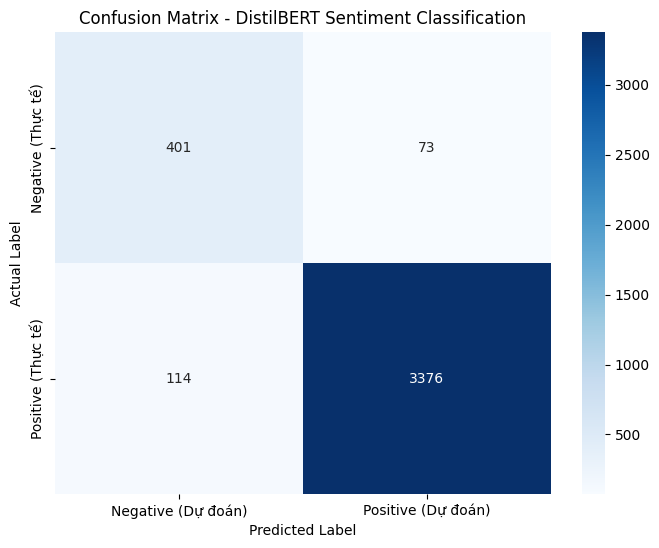

In [ ]:
#4phút
import pandas as pd
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import TextClassificationPipeline
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertConfig, DistilBertPreTrainedModel, DistilBertModel
import torch.nn as nn
from torch.nn import CrossEntropyLoss

# --- 1. Tải và Xử lý Dữ liệu ---
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

df = df.dropna(subset=['Review Text', 'Rating'])

df = df[df['Rating'] != 3]

df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x > 3 else 0)
print(f"Số lượng mẫu sau khi xử lý ban đầu: {len(df)}")
print(f"Phân bổ tình cảm:\n{df['Sentiment'].value_counts()}")
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=df['Sentiment'].values)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Trọng số lớp: {class_weights}")
# --- 2. Tiền xử lý văn bản ---
def clean_text(text):
    """
    Hàm làm sạch văn bản:
    - Chuyển thành chữ thường
    - Loại bỏ số
    - Loại bỏ các ký tự đặc biệt (giữ lại chữ, số và khoảng trắng)
    """
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip()
    return text

df['Cleaned Review'] = df['Review Text'].apply(clean_text)

print("\nVí dụ về văn bản sau khi làm sạch:")
for i in range(min(3, len(df))): 
    print(f"Gốc: {df['Review Text'].iloc[i]}")
    print(f"Làm sạch: {df['Cleaned Review'].iloc[i]}\n")

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Cleaned Review'].tolist(),
    df['Sentiment'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['Sentiment'].tolist()
)
print(f"Số lượng mẫu huấn luyện: {len(train_texts)}")
print(f"Số lượng mẫu kiểm tra: {len(test_texts)}")

# --- 4. Tokenizer DistilBERT ---
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# --- 5. Tạo Dataset PyTorch ---
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)
class WeightedDistilBERT(DistilBertPreTrainedModel):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.hidden_size, config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)
        self.class_weights = class_weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs[0]                  
        pooled_output = hidden_state[:, 0]         
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits, labels)

        return {'loss': loss, 'logits': logits} if loss is not None else {'logits': logits}

# --- 6. Mô hình DistilBERT ---
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2)
model = WeightedDistilBERT.from_pretrained('distilbert-base-uncased', config=config, class_weights=class_weights)
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1) 
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary') 
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# --- 7. Tham số Huấn luyện ---
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy", 
    report_to="none",
    learning_rate=5e-5,
    warmup_steps=500,
    weight_decay=0.01,
)

# --- 8. Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics 
)

print("\nBắt đầu huấn luyện mô hình...")
trainer.train()
print("Huấn luyện hoàn tất.")

# --- 9. Đánh giá ---
print("\nĐánh giá mô hình trên tập kiểm tra...")
predictions_output = trainer.predict(test_dataset)

print("\nKết quả đánh giá từ Trainer.predict:")
if predictions_output.metrics:
    for key, value in predictions_output.metrics.items():
        print(f"{key}: {value}")

y_pred_logits = predictions_output.predictions
y_pred = np.argmax(y_pred_logits, axis=-1)
y_true = predictions_output.label_ids 

print("\nAccuracy (tính thủ công):", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

# --- 10. Ma trận nhầm lẫn ---
print("\nĐang vẽ ma trận nhầm lẫn...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative (Dự đoán)", "Positive (Dự đoán)"],
            yticklabels=["Negative (Thực tế)", "Positive (Thực tế)"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - DistilBERT Sentiment Classification")
plt.savefig("confusion_matrix_distilbert.png")
print("Đã lưu ma trận nhầm lẫn vào file: confusion_matrix_distilbert.png")


device_to_use = 0 if torch.cuda.is_available() else -1
if device_to_use == 0:
    print(f"\nSử dụng GPU: {torch.cuda.get_device_name(0)}")
else:
    print("\nSử dụng CPU cho pipeline.")

pipeline = TextClassificationPipeline(
    model=trainer.model,
    tokenizer=tokenizer,
    return_all_scores=False,
    device=device_to_use
)

new_reviews = [
    "This dress is fantastic! I love it!",
    "The fabric is terrible and it ripped easily.",
    "I am very satisfied with this purchase, great quality!",
    "Poorly made, not worth the money.",
    "Absolutely love this! Fits perfectly.",
    "Not happy at all, bad experience.",
    "Wonderful fabric and excellent design!",
    "Size was incorrect and material feels cheap.",
    "The product is okay, not great but not bad either.",
    "I'm on the fence about this one."
]

print("\nKết quả dự đoán cho các review mới:")
cleaned_new_reviews = [clean_text(review) for review in new_reviews]
preds = pipeline(cleaned_new_reviews)

for review, pred_output in zip(new_reviews, preds):
    sentiment = "Positive" if pred_output['label'] == 'LABEL_1' else "Negative"
    score = pred_output['score']
    print(f"Review: \"{review}\" -> Sentiment: {sentiment} (Score: {score:.4f})")

print("\nLưu mô hình và tokenizer...")
model_save_path = "./saved_distilbert_sentiment_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Đã lưu mô hình và tokenizer vào: {model_save_path}")

print("\nHoàn thành script.")